## LangGraph + RAG

In [1]:
!pip install -q langgraph langchain langchain-openai langchain-community faiss-cpu python-dotenv

In [2]:
from dotenv import load_dotenv
load_dotenv()

from typing import TypedDict

from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


### Przygotowanie bazy dokumentów

In [5]:
docs = [
    "LangChain to framework do pracy z dużymi modelami językowymi.",
    "LangGraph pozwala na budowanie workflowów w postaci grafów stanów.",
    "Retrieval-Augmented Generation (RAG) łączy wyszukiwanie kontekstu i generowanie odpowiedzi.",
    "FAISS to biblioteka do wyszukiwania najbliższych wektorów w embeddingach."
]

# Chunkowanie
splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=10)
splits = splitter.create_documents(docs)

# Indeks wektorowy
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(splits, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})


### Definicja stanu

In [4]:
class State(TypedDict):
    question: str
    context: str
    answer: str
    pass_eval: bool

### Węzeł retrieval

In [20]:
def retrieval(state: State) -> State:
    docs = retriever.invoke(state["question"])
    context = "\n".join([d.page_content for d in docs])
    return {"context": context}

### Węzeł generowania

In [13]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Jesteś asystentem, który odnajduje informacje w dokumentach. Odpowiadaj tylko na podstawie KONTEKSTU:\n{context}"),
    ("user", "{question}")
])

def generation(state: State) -> State:
    response = (prompt | llm).invoke({
        "context": state["context"],
        "question": state["question"]
    })
    return {"answer": response.content}

### Węzeł ewaluacji

In [8]:
eval_prompt = ChatPromptTemplate.from_messages([
    ("system", "Oceń odpowiedź."),
    ("user", "Pytanie: {question}\nOdpowiedź: {answer}\nCzy odpowiedź zawiera rozwiązanie? Odpowiedz tylko 'yes' lub 'no'.")
])

def eval_node(state: State) -> State:
    response = (eval_prompt | llm).invoke({
        "question": state["question"],
        "answer": state["answer"]
    })
    result = response.content.strip().lower().startswith("yes")
    return {"pass_eval": result}


### Węzeł końcowy

In [9]:
def finish(state: State) -> State:
    if state["pass_eval"]:
        print(f"✅ Odpowiedź zaakceptowana: {state['answer']}")
    else:
        print("❌ Odpowiedź nie zawiera rozwiązania.")
    return state

### Budowa grafu z pętlą

In [22]:
graph = StateGraph(State)

graph.add_node("retrieval", retrieval)
graph.add_node("generation", generation)
graph.add_node("eval", eval_node)
graph.add_node("finish", finish)

graph.set_entry_point("retrieval")
graph.add_edge("retrieval", "generation")
graph.add_edge("generation", "eval")

def check_eval(state: State):
    return "finish" if state["pass_eval"] else "generation"

graph.add_conditional_edges("eval", check_eval, ["finish", "generation"])
graph.add_edge("finish", END)

app = graph.compile(debug=True)

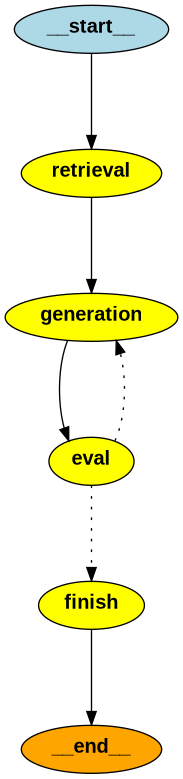

In [18]:
# Wizualizacja grafu
from IPython.display import Image, display

png_bytes = app.get_graph().draw_png()
display(Image(png_bytes))

### Uruchomienie grafu

In [23]:
app.invoke({"question": "Czym jest LangGraph?"})

[values] {'question': 'Czym jest LangGraph?'}
[updates] {'retrieval': {'context': 'LangGraph pozwala na budowanie workflowów w postaci grafów stanów.\nLangChain to framework do pracy z dużymi modelami językowymi.'}}
[values] {'question': 'Czym jest LangGraph?', 'context': 'LangGraph pozwala na budowanie workflowów w postaci grafów stanów.\nLangChain to framework do pracy z dużymi modelami językowymi.'}
[updates] {'generation': {'answer': 'LangGraph pozwala na budowanie workflowów w postaci grafów stanów.'}}
[values] {'question': 'Czym jest LangGraph?', 'context': 'LangGraph pozwala na budowanie workflowów w postaci grafów stanów.\nLangChain to framework do pracy z dużymi modelami językowymi.', 'answer': 'LangGraph pozwala na budowanie workflowów w postaci grafów stanów.'}
[updates] {'eval': {'pass_eval': True}}
[values] {'question': 'Czym jest LangGraph?', 'context': 'LangGraph pozwala na budowanie workflowów w postaci grafów stanów.\nLangChain to framework do pracy z dużymi modelami j

{'question': 'Czym jest LangGraph?',
 'context': 'LangGraph pozwala na budowanie workflowów w postaci grafów stanów.\nLangChain to framework do pracy z dużymi modelami językowymi.',
 'answer': 'LangGraph pozwala na budowanie workflowów w postaci grafów stanów.',
 'pass_eval': True}